# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import glob

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

import skimage.color
import skimage.io
import skimage.transform

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")


# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


Using TensorFlow backend.


In [2]:
def CmpWord(a,b):
    n = 0
    cnt = 0
    if len(a)==len(b):
        return False

    else:
        if len(b) > len(a):
            tmp = a
            a = b
            b = tmp

        for i in range(31):#18
            if b[i] != a[n]:
                cnt +=1
                #b = b[0:n] + a[n] + b[n:]
            n+=1
        #print(cnt)    
        if cnt == 0:
            return True
        else:
            return False


In [3]:
#os.chdir('D:\Share_D\Shc')
#path = "./"


spinelist1 = []
spinelist1_train = []
spinelist1_val = []
spinelist1_mask = []
list1 = []
list2 = []
list2_train = []
list2_val = []

for filename in glob.iglob('D:/TestSpine/**/*s_crop00.jpg', recursive=True): 
    spinelist1.append(filename) 

for filename in glob.iglob('D:/TestSpine/**/*S.png', recursive=True):  
    spinelist1_mask.append(filename)            
   


#print("len(spinelist1)=", len(spinelist1))
#print("len(spinelist1_mask)=", len(spinelist1_mask))

for i in range(len(spinelist1)):
        for j in range(len(spinelist1_mask)):
            if(CmpWord(spinelist1[i],spinelist1_mask[j])==True):
                #print(spinelist1_mask[j]) 
                list1.append(spinelist1_mask[j])
        list2.append(list1)
        list1= []

print("len(spinelist1)=", len(spinelist1))
print(spinelist1[1])
print(list2[1])       
print(list2[30][(len(list2[30])-1)])       
print(list2[30][(len(list2[30])-2)])       
print(list2[30][(len(list2[30])-3)])       
#print([i for i in enumerate(list2)])
#print(spinelist1[0],spinelist1_mask[10])
#CmpWord(spinelist1[0],spinelist1_mask[10])

train_len = int(len(spinelist1) * 0.7)
val_len = len(spinelist1) - train_len

#----------------------------------------------------
for i in range(train_len):
    spinelist1_train.append(spinelist1[i])
    list2_train.append(list2[i])

print("len(spinelist1_train)=", len(spinelist1_train))
print("spinelist1_train[30]=", spinelist1_train[30])
print("spinelist1[30]=", spinelist1[30])

#----------------------------------------------------
for i in range(val_len):
    j = i + train_len
    spinelist1_val.append(spinelist1[j])
    list2_val.append(list2[j])

print("len(spinelist1_val)=", len(spinelist1_val))
    
print("spinelist1_val[30]=", spinelist1_val[30])
print("spinelist1[train_len+30]=", spinelist1[train_len+30])

len(spinelist1)= 127
D:/TestSpine\2020.01.06\F04\F04s_crop00.jpg
['D:/TestSpine\\2020.01.06\\F04\\F04_V08_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V09_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V10_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V11_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V12_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V13_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V14_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V15_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V16_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V17_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V18_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V19_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V20_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V21_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V22_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V23_S.png', 'D:/TestSpine\\2020.01.06\\F04\\F04_V24_S.png']
D:/TestSpine\2020.01.10\T014\T_014_V24_S.png
D:/TestSpine\2020.01.10\T014\T_014_V23_S.png
D:/TestSpine\2020.01.10\T014

## Configurations

In [4]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [6]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width, start_index):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        
        self.start_index = start_index
        # Add classes
        self.add_class("shapes", 1, "V24")
        self.add_class("shapes", 2, "V23")
        self.add_class("shapes", 3, "V22")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)
            

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        #print("image_id+self.start_index=", image_id+self.start_index)
        image = cv2.imread(spinelist1[image_id+self.start_index]) #이미지 불러오기
        #print("spinelist1[image_id+self.start_index]=", spinelist1[image_id+self.start_index])
        return image
    
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        set = ""
        #shapes: [('V24', (7, 179, 14), (92, 30, 28)), ('V23', (134, 149, 62), (43, 59, 32)), ('V24', (41, 29, 211), (63, 104, 32))]

        #print("list2[image_id+self.start_index]=", list2[image_id+self.start_index])
        #print("image_id=", image_id)
        #print("self.start_index=", image_id)
        info = self.image_info[image_id]
        shapes = info['shapes']       
        image_id2 = image_id+self.start_index
        mask_image1 = cv2.imread(list2[image_id2][(len(list2[image_id2])-1)]) #V24 이미지 불러오기
        mask_image2 = cv2.imread(list2[image_id2][(len(list2[image_id2])-2)]) #V23 이미지 불러오기
        mask_image3 = cv2.imread(list2[image_id2][(len(list2[image_id2])-3)]) #V22 이미지 불러오기
        mask_height, mask_width, mask_channel = mask_image1.shape
        #print("mask_width, mask_height=", [mask_width, mask_height])
        """
        if(shapes[0][0]=="V24"):
            mask_image = cv2.imread(list2[image_id][(len(list2[image_id])-1)]) #V24 이미지 불러오기     
            set =list2[image_id][(len(list2[image_id])-1)] #V24 이미지 불러오기    
        elif(shapes[0][0]=="V23"):
            mask_image = cv2.imread(list2[image_id][(len(list2[image_id])-2)]) #V23 이미지 불러오기        
            set =list2[image_id][(len(list2[image_id])-2)]    
        else:
            mask_image = cv2.imread(list2[image_id][(len(list2[image_id])-3)]) #V22 이미지 불러오기 
            set =list2[image_id][(len(list2[image_id])-3)]
        print("mask_image:",set) 
        print("info:" ,info)       
        print("shapes:",shapes[0][0])
        """ 
        count = len(shapes)        
        mask = np.zeros([info['width'],info['height'], count], dtype=np.uint8)
        #print("mask:",mask)
        # Get the center x, y and the size s

        #print("info['height'],info['width']=",info['height'],info['width'])
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        #class_ids = np.array([self.class_names.index(s[0]) for s in shapes])       
        class_ids = np.zeros(3, dtype=np.int32)
        class_ids[0] = 1
        class_ids[1] = 2
        class_ids[2] = 3
        
        #print("class_ids=", class_ids)
        #mask = np.array(mask_image, dtype=np.uint8)
        
        mask = np.zeros([mask_height, mask_width, 3], dtype=np.uint8)
        mask[:,:,0] = mask_image1[:,:,0]
        mask[:,:,1] = mask_image2[:,:,0]
        mask[:,:,2] = mask_image3[:,:,0]
          
        return mask.astype(np.bool), class_ids.astype(np.int32)
    
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)
        """

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'V24':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "V23":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "V22":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)

        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["V24", "V23", "V22"])
        #shape = shape_type
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        shape_type =["V24", "V23", "V22"]
        #N = random.randint(1, 3)
        N = 3
        for _ in range(N): #N이였음
            shape, color, dims = self.random_shape(height, width)
            shape = shape_type[_]            
            shapes.append((shape, color, dims))
            print("shape in random shape:",shapes)
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        #shapes = [s for i, s in range(3) if i in keep_ixs]
        return bg_color, shapes

In [7]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(len(spinelist1_train), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 0)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(len(spinelist1_val), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], len(spinelist1_train))
dataset_val.prepare()

shape in random shape: [('V24', (70, 212, 67), (88, 60, 30))]
shape in random shape: [('V24', (70, 212, 67), (88, 60, 30)), ('V23', (176, 56, 70), (54, 69, 24))]
shape in random shape: [('V24', (70, 212, 67), (88, 60, 30)), ('V23', (176, 56, 70), (54, 69, 24)), ('V22', (17, 7, 90), (93, 48, 28))]
shape in random shape: [('V24', (165, 136, 217), (44, 89, 28))]
shape in random shape: [('V24', (165, 136, 217), (44, 89, 28)), ('V23', (216, 24, 145), (52, 91, 20))]
shape in random shape: [('V24', (165, 136, 217), (44, 89, 28)), ('V23', (216, 24, 145), (52, 91, 20)), ('V22', (51, 125, 225), (74, 46, 23))]
shape in random shape: [('V24', (214, 30, 133), (50, 61, 21))]
shape in random shape: [('V24', (214, 30, 133), (50, 61, 21)), ('V23', (80, 237, 159), (80, 43, 25))]
shape in random shape: [('V24', (214, 30, 133), (50, 61, 21)), ('V23', (80, 237, 159), (80, 43, 25)), ('V22', (120, 173, 228), (27, 43, 24))]
shape in random shape: [('V24', (179, 167, 20), (27, 27, 32))]
shape in random shape: 

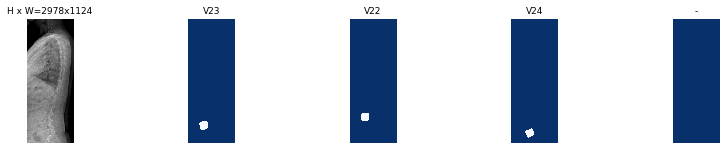

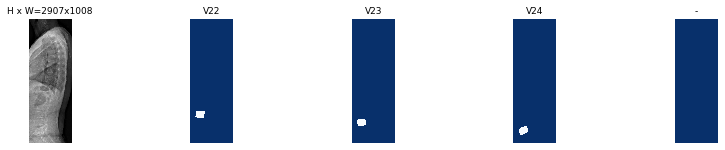

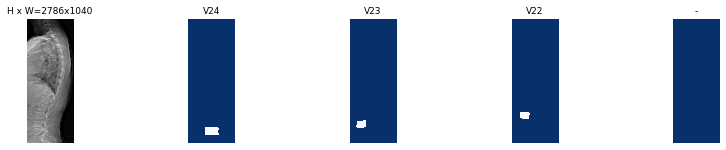

'\nimage_ids = np.random.choice(dataset_train.image_ids, 4)\nfor image_id in image_ids:\n    print("image_id=", image_id)\n    image = dataset_train.load_image(image_id)\n    print("image.shape=", image.shape)\n    print("image.dtype=", image.dtype)\n    mask, class_ids = dataset_train.load_mask(image_id)\n    print("mask.shape=", mask.shape)\n    print("mask.dtype=", mask.dtype)\n    print("class_ids=", class_ids)\n    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)\n'

In [8]:
# Load and display random samples

#image_ids = np.random.choice(dataset_train.image_ids, 1)

#print("dataset_train.image_ids:",dataset_train.image_ids)

#for image_id in image_ids:
#    print("spinelist1[image_id+dataset_val.start_index]=", spinelist1[image_id+dataset_train.start_index])
#    print("spinelist1_train[image_id]=", spinelist1_train[image_id])
#    image = dataset_train.load_image(image_id)
#    mask, class_ids = dataset_train.load_mask(image_id)
#    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)  

image_ids = np.random.choice(dataset_val.image_ids, 3)

for image_id in image_ids:
    #print("---------------------------------------------")
    #print("image_id=", image_id)
    #print("spinelist1[image_id+dataset_val.start_index]", spinelist1[image_id+dataset_val.start_index])
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)  


"""
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    print("image_id=", image_id)
    image = dataset_train.load_image(image_id)
    print("image.shape=", image.shape)
    print("image.dtype=", image.dtype)
    mask, class_ids = dataset_train.load_mask(image_id)
    print("mask.shape=", mask.shape)
    print("mask.dtype=", mask.dtype)
    print("class_ids=", class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
"""    

## Create Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


In [10]:
# Which weights to start with?
#init_with = "coco"  # imagenet, coco, or last
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 147


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100,
            layers='heads')


Starting at epoch 147. LR=0.001

Checkpoint Path: D:\Mask_RCNN-Tensorflow\logs\shapes20200203T1801\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_

c:\users\user\anaconda2\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=200, 
            layers="all")


Starting at epoch 147. LR=0.0001

Checkpoint Path: D:\Mask_RCNN-Tensorflow\logs\shapes20200203T1801\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_

100/100 [==============================] - 246s 2s/step - loss: 0.1254 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.1023 - val_loss: 4.3281 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 0.3574 - val_mrcnn_class_loss: 1.1112 - val_mrcnn_bbox_loss: 0.6333 - val_mrcnn_mask_loss: 2.2198
Epoch 149/200
100/100 [==============================] - 146s 1s/step - loss: 0.1263 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0085 - mrcnn_mask_loss: 0.1031 - val_loss: 3.6070 - val_rpn_class_loss: 0.0110 - val_rpn_bbox_loss: 0.4606 - val_mrcnn_class_loss: 0.6518 - val_mrcnn_bbox_loss: 0.5385 - val_mrcnn_mask_loss: 1.9451
Epoch 150/200
100/100 [==============================] - 147s 1s/step - loss: 0.1265 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0082 - mrcnn_mask_loss: 0.1017 - val_loss: 3.7458 - val_rpn_class_loss: 

Epoch 170/200
100/100 [==============================] - 144s 1s/step - loss: 0.1217 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0991 - val_loss: 4.0753 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.3903 - val_mrcnn_class_loss: 1.0756 - val_mrcnn_bbox_loss: 0.5814 - val_mrcnn_mask_loss: 2.0188
Epoch 171/200
100/100 [==============================] - 145s 1s/step - loss: 0.1181 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0028 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0945 - val_loss: 2.7771 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.3984 - val_mrcnn_class_loss: 0.3928 - val_mrcnn_bbox_loss: 0.4770 - val_mrcnn_mask_loss: 1.5003
Epoch 172/200
100/100 [==============================] - 146s 1s/step - loss: 0.1211 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0996 - val_loss: 3.0519 - val_rp

100/100 [==============================] - 148s 1s/step - loss: 0.1125 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0922 - val_loss: 4.8316 - val_rpn_class_loss: 0.0127 - val_rpn_bbox_loss: 0.3613 - val_mrcnn_class_loss: 1.4275 - val_mrcnn_bbox_loss: 0.5823 - val_mrcnn_mask_loss: 2.4477
Epoch 192/200
100/100 [==============================] - 149s 1s/step - loss: 0.1153 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0027 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0951 - val_loss: 3.6487 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.4427 - val_mrcnn_class_loss: 0.8113 - val_mrcnn_bbox_loss: 0.5026 - val_mrcnn_mask_loss: 1.8829
Epoch 193/200
100/100 [==============================] - 146s 1s/step - loss: 0.1055 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0023 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0898 - val_loss: 2.5703 - val_rpn_class_loss: 

In [13]:
#Save weights
#Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [14]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  D:\Mask_RCNN-Tensorflow\logs\shapes20200203T1801\mask_rcnn_shapes_0200.h5
Re-starting from epoch 200


original_image           shape: (128, 128, 3)         min:    0.00000  max:  208.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 3215.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:   50.00000  max:  123.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


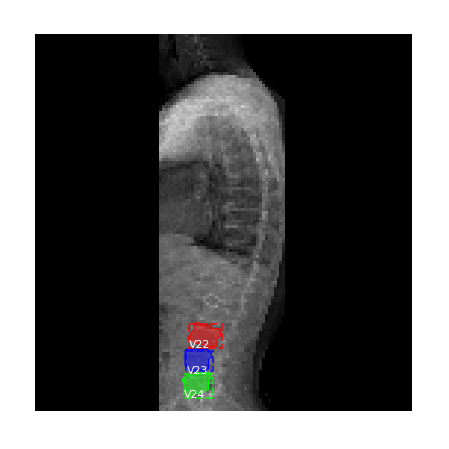

In [33]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  208.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  104.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


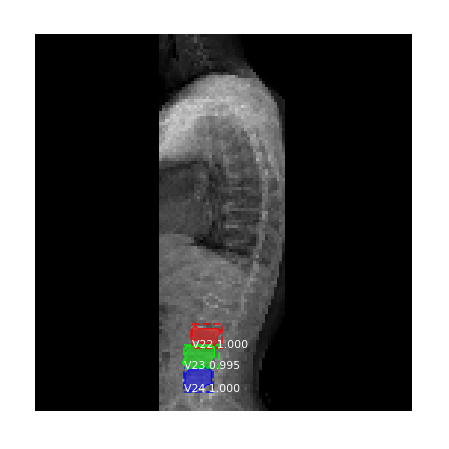

In [34]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [35]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.3666666686534882
